# Neural network content-based Recommendation model 

Using users (e.g., preferences for each of the defined genres (0-5)) and movies (e.g., binary attribute indicating whether or not a movie is part of a certain genre (1.0)) content, train the model to predict movie recommendations. In this case specifically, since we are not going to have users, we are going to focus on how similar a movie is to other movies.

The dataset contains: 
- **847** movies
- **397** users
- **14** genres
- **25,521** ratings

**Feature engineering is applied repeating some ratings to boost underrepresented genres.**

## Goal

Compute the distance between movies using the features trained by the neural network model. This distance is saved in a **2D matrix** so that the calculation of the distance is as follows: 

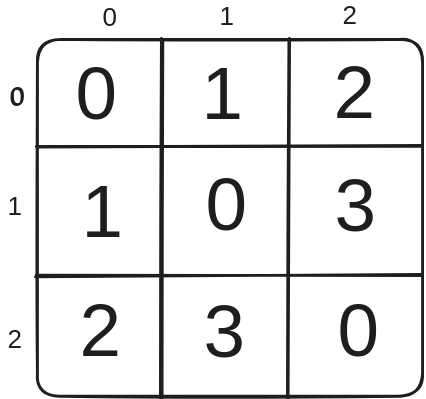

**i**: Movie<sub>i</sub> index in the matrix

**j**: Movie<sub>j</sub> index in the matrix 

**distance**: matrix[i][j]

<br/>

In order to improve the accuracy of the recommendation, instead of just picking the closest movie from **movie<sub>i</sub>**, say **movie<sub>j</sub>**, we can take a list of movies and compute the sum of the distance from the movies in the list with each movie in the dataset. After that, we take the least sum.

One disadvantage of the approach defined above is that it might give inaccurate predictions for a movie list that is too sparse, i.e., movies are not similar. Otherwise, it can be efficient for finding a similar movie with more accuracy.

The **UI implementation follows the exact method defined above**, allowing the user to pick 3 movies. 

## Credits

Most of the resources come from assignments on the [Machine Learning Specialization](https://www.coursera.org/learn/machine-learning/home/welcome).

The dataset is derived from the [MovieLens ml-latest-small dataset](https://grouplens.org/datasets/movielens/latest/).

[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19.](https://doi.org/10.1145/2827872)


In [24]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
from utils import *
from operator import itemgetter
import json

## Data format

Below we have a sample of the dataset, each sample line contains the following:

1. **user_train**: user content (preferences for each genre)
2. **item_train**: movie content (year, avg rating and genres in one-hot-encoding)
3. **y_train**: user rating for the movie


**The columns between brackets ([column]), are not gonna be used during the learning.**

In [3]:
item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre = load_data()

num_user_features = user_train.shape[1] - 3 # Removes user id, rating couting and avg rating
num_item_features = item_train.shape[1] - 1 # Remove movie id
uvs = 3 # user genre vector start
ivs = 3 # item genre vector start
u_s = 3 # user start of features columns to use in training
i_s = 1 # items start of features columns to use in training

In [4]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)

[user id],[rating count],[rating ave],Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9
2,22,4.0,4.0,4.2,0.0,0.0,4.0,4.1,4.0,4.0,0.0,3.0,4.0,0.0,3.9,3.9


In [5]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)

[movie id],year,ave rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
6874,2003,4.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
8798,2004,3.8,1,0,0,0,0,1,0,1,0,0,0,0,0,1
46970,2006,3.2,1,0,0,0,1,0,0,0,0,0,0,0,0,0
48516,2006,4.3,0,0,0,0,0,1,0,1,0,0,0,0,0,1
58559,2008,4.2,1,0,0,0,0,1,0,1,0,0,0,0,0,0


In [6]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [4.  3.5 4.  4.  4.5]


## Feature scaling

Below feature scalling is applied to normalize the data in the range (-1<=x<=1). This enables for faster convergence.

In [7]:
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))

# Dataset split

In order to have a accurate estimation of our model, below we split 80% of it for the training set and the rest (20%) for the test set.

In [8]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test = train_test_split(y_train, train_size = 0.80, shuffle=True, random_state=1)

In [9]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)

[user id],[rating count],[rating ave],Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
1,0,-1.0,-0.8,-0.7,0.1,-0.0,-1.2,-0.4,0.6,-0.5,-0.5,-0.1,-0.6,-0.6,-0.7,-0.7
0,1,-0.7,-0.5,-0.7,-0.1,-0.2,-0.6,-0.2,0.7,-0.5,-0.8,0.1,-0.0,-0.6,-0.5,-0.4
-1,-1,-0.2,0.3,-0.4,0.4,0.5,1.0,0.6,-1.2,-0.3,-0.6,-2.3,-0.1,0.0,0.4,-0.0
0,-1,0.6,0.5,0.5,0.2,0.6,-0.1,0.5,-1.2,0.9,1.2,-2.3,-0.1,0.0,0.2,0.3
-1,0,0.7,0.6,0.5,0.3,0.5,0.4,0.6,1.0,0.6,0.3,0.8,0.8,0.4,0.7,0.7


# Neural Network

Below we have the Neural Network definition, 2 hidden layers containing, respectively, 512 and 256 neurons each and an output layer of 32. That is, the features vector are of length 32.

We define this same schema for both the user and the movie neural network. After that, since the features vectors are of equal size, we compute the dot product and try to minimize it compared to the user rating.

In [10]:
num_outputs = 32

user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear')
])

item_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear')
])

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

output = tf.keras.layers.Dot(axes=1)([vu, vm])

model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   147232    ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32)                   148256    ['input_2[0][0]']             
                                                                                              

In [11]:
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [12]:
model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=100)

Epoch 1/100
1273/1273 [==============================] - 11s 8ms/step - loss: 0.1248
Epoch 2/100
1273/1273 [==============================] - 12s 9ms/step - loss: 0.1160
Epoch 3/100
1273/1273 [==============================] - 13s 10ms/step - loss: 0.1117
Epoch 4/100
1273/1273 [==============================] - 11s 9ms/step - loss: 0.1079
Epoch 5/100
1273/1273 [==============================] - 9s 7ms/step - loss: 0.1033
Epoch 6/100
1273/1273 [==============================] - 10s 8ms/step - loss: 0.1004
Epoch 7/100
1273/1273 [==============================] - 9s 7ms/step - loss: 0.0977
Epoch 8/100
1273/1273 [==============================] - 11s 8ms/step - loss: 0.0953
Epoch 9/100
1273/1273 [==============================] - 11s 9ms/step - loss: 0.0935
Epoch 10/100
1273/1273 [==============================] - 11s 9ms/step - loss: 0.0915
Epoch 11/100
1273/1273 [==============================] - 8s 7ms/step - loss: 0.0897
Epoch 12/100
1273/1273 [==============================] - 8s 7ms/

In [13]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

319/319 [==============================] - 1s 2ms/step - loss: 0.0754


0.07537809014320374

# Movies distance calculation

Below we define the distance calculation functions and a second model to compute the movies vector. As you can see, we are using the **item_NN** neural network trained previously in order to take just the movies vector. 

In [14]:
def sq_distance(a, b):
    return np.sum((a - b) ** 2)

In [15]:
def compute_distance_matrix(vms):
    m = vms.shape[0]
    M = np.zeros((m, m))

    for i in range(m):
        for j in range(m):
            M[i][j] = sq_distance(vms[i, :], vms[j, :])

    return M

In [16]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features))
vm_m = item_NN(input_item_m)
vm_m = tf.linalg.l2_normalize(vm_m, axis=1)
model_m = tf.keras.Model(input_item_m, vm_m)
model_m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 sequential_1 (Sequential)   (None, 32)                148256    
                                                                 
 tf.math.l2_normalize_2 (TF  (None, 32)                0         
 OpLambda)                                                       
                                                                 
Total params: 148256 (579.12 KB)
Trainable params: 148256 (579.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs[:,i_s:])

27/27 [==============================] - 0s 3ms/step


# Distance matrix

Below we compute the distance matrix and use it to calculate the top 10 most similar movies 

In [18]:
distance_matrix = compute_distance_matrix(vms)

In [19]:
m = distance_matrix.shape[0]
similar_movies_list = []

distance_matrix = ma.masked_array(distance_matrix, mask=np.identity(distance_matrix.shape[0]))

for i in range(m):
    movie = dict()
    min_idx = np.argmin(distance_matrix[i, i:])
    movie1_id = int(item_vecs[i, 0])
    movie2_id = int(item_vecs[min_idx, 0])
    distance = distance_matrix[i][min_idx]
    movie["movie1_id"] = movie1_id
    movie["movie2_id"] = movie2_id
    movie["distance"] = distance 
    
    similar_movies_list.append(movie)

In [20]:
top_10_similar_movies = sorted(similar_movies_list, key=itemgetter('distance'))[0:9]

In [21]:
disp = [["movie1", "movie1_id", "genres", "movie2", "movie2_id", "genres", "distance"]]

for i in range(len(top_10_similar_movies)):
    movie1_id = top_10_similar_movies[i]["movie1_id"]
    movie2_id = top_10_similar_movies[i]["movie2_id"]
    distance = top_10_similar_movies[i]["distance"]
    disp.append([
        movie_dict[movie1_id]["title"], movie1_id, movie_dict[movie1_id]["genres"],
        movie_dict[movie2_id]["title"], movie2_id, movie_dict[movie2_id]["genres"],
        distance
    ])

table = tabulate.tabulate(disp, tablefmt="html", headers="firstrow")
table

movie1,movie1_id,genres,movie2,movie2_id,genres,distance
Knocked Up (2007),52973,Comedy|Drama|Romance,Punch-Drunk Love (2002),5673,Comedy|Drama|Romance,0.125944
Save the Last Dance (2001),4054,Drama|Romance,Mona Lisa Smile (2003),7154,Drama|Romance,0.193816
"Benchwarmers, The (2006)",44840,Comedy,Scary Movie 2 (2001),4388,Comedy,0.19601
Up in the Air (2009),72011,Drama|Romance,"Pianist, The (2002)",5995,Drama,0.262993
Enemy at the Gates (2001),4223,Drama,Lord of War (2005),36529,Action|Crime|Drama|Thriller,0.283507
Saved! (2004),8366,Comedy|Drama,Punch-Drunk Love (2002),5673,Comedy|Drama|Romance,0.31291
"Das Experiment (Experiment, The) (2001)",5608,Drama|Thriller,Planet Terror (2007),54995,Action|Horror|Sci-Fi,0.339971
"Blind Swordsman: Zatoichi, The (Zatôichi) (2003)",8370,Action|Comedy|Crime|Drama,Mean Girls (2004),7451,Comedy,0.377449
Slumdog Millionaire (2008),63082,Crime|Drama|Romance,Adaptation (2002),5902,Comedy|Drama|Romance,0.39414


# Saving the model output

The JSON file contains two keys:

- **vector**: A list of all the movies ids (their indices are their exact row index in the matrix).
- **matrix**: The distance matrix

In [22]:
recommendations = dict()

recommendations["vector"] = item_vecs[:, 0].astype(int).tolist()
recommendations["matrix"] = distance_matrix.tolist()

with open("./output/recommendations.json", "w", encoding="utf-8") as f:
    json.dump(recommendations, f, ensure_ascii=True, indent=4)

# How to use the pre computed output?

Below there is an easy example to calculate the distance between two movies given their ids.

In [23]:
movie_a_id = 4054 # Save the Last Dance (2001)
movie_b_id = 7154 # Mona Lisa Smile (2003)	
movie_a_title = movie_dict[movie_a_id]["title"]
movie_b_title = movie_dict[movie_b_id]["title"]
movie_a_matrix_idx = recommendations["vector"].index(movie_a_id)
movie_b_matrix_idx = recommendations["vector"].index(movie_b_id)
movies_a_b_distance = recommendations["matrix"][movie_a_matrix_idx][movie_b_matrix_idx]

print(f"Distance between \"{movie_a_title}\" (movie A) and \"{movie_b_title}\" (movie B) is {movies_a_b_distance}")

Distance between "Save the Last Dance (2001)" (movie A) and "Mona Lisa Smile (2003)" (movie B) is 0.1938161849975586
